In [112]:
import re
import os
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Step 1. 실험환경 Set-up

In [113]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 32

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 15

In [114]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


# Step 2. 데이터 준비하기

In [115]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [116]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/train/NORMAL/IM-0704-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/train/PNEUMONIA/person1376_bacteria_3511.jpeg


In [117]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1082
Pneumonia images count in training set: 3103


In [118]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [119]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [120]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [121]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [122]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [123]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [124]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [125]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [126]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [127]:
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화

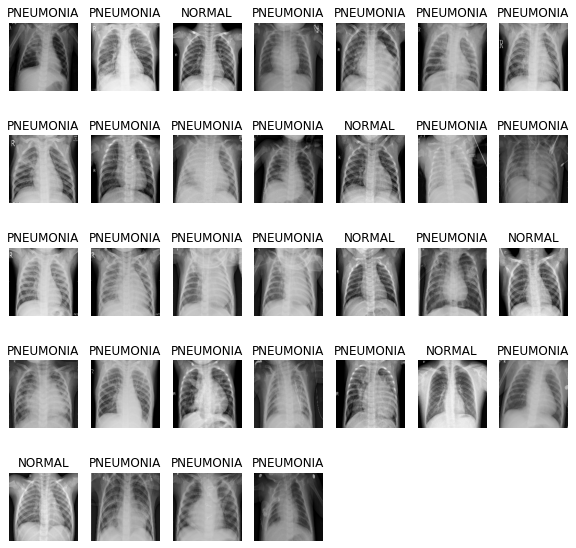

In [128]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링

In [129]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [130]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [131]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance처리

In [132]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67


In [133]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_24 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_25 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_26 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_13 (Dropout)         (None, 11, 11, 128)     

In [134]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 70s 455ms/step - loss: 0.4936 - accuracy: 0.7374 - precision: 0.9192 - recall: 0.7109 - val_loss: 0.5812 - val_accuracy: 0.7432 - val_precision: 0.7432 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 58s 449ms/step - loss: 0.2124 - accuracy: 0.9226 - precision: 0.9785 - recall: 0.9163 - val_loss: 0.7228 - val_accuracy: 0.7432 - val_precision: 0.7432 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 58s 450ms/step - loss: 0.1892 - accuracy: 0.9287 - precision: 0.9803 - recall: 0.9230 - val_loss: 1.0019 - val_accuracy: 0.7432 - val_precision: 0.7432 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 59s 458ms/step - loss: 0.1577 - accuracy: 0.9437 - precision: 0.9788 - recall: 0.9446 - val_loss: 1.3878 - val_accuracy: 0.7510 - val_precision: 0.7510 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 62s 477ms/step - loss: 0.1378 - accura

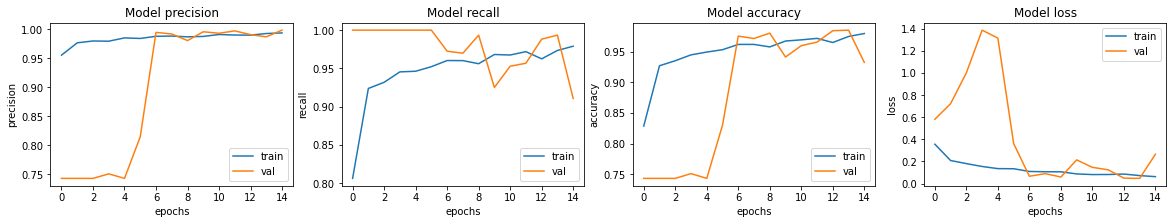

In [135]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [136]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 6s 278ms/step - loss: 0.5879 - accuracy: 0.8638 - precision: 0.8640 - recall: 0.9282
Loss: 0.587947428226471,
Accuracy: 0.8637820482254028,
Precision: 0.8639618158340454,
Recall: 0.928205132484436


# 회고
- 처음에 그냥 따라서 해보니깐 정확도가 80% 나왔다.
- 처음부터 오류가 나서 당황했지만 파일을 불러오는 코드에서 train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
로 고치니깐 오류가 고쳐졌다. str()로 묶어줘야 되는 것 같다.

#### 기본 셋팅
- 배치사이즈 16, epoch 40, 
- 좌우 반전 정도의 augmentation, BachNormalization, Dropout 사용

#### ablation study
1. 좌우 반전 정도의 augmentation 제거  
     Accuracy: 0.817307710647583
     
 
2. BachNormalization 제거  
     Accuracy: 0.625
     
     
3. Dropout 제거  
    Accuracy: 0.7932692170143127


4. BachNormalization + Dropout 제거  
    Accuracy: 0.375


5. epoch 15  
    Accuracy: 0.8125
    

6. 배치사이즈 32  
    Accuracy: 0.8429487347602844

### 결과
1)  augmentation 이 없을 때,  
2)  BachNormalization이 있을 때,  
3)  Dropout이 있을 때,   
4)  epoch가 15일 때,  
5)  배치사이즈가 32일 때   
정확도가 높다는 것을 알게되었다.  


#### 최종 모델 
배치사이즈 32, epoch 15로 바꾸고 노이즈를 안 넣은 모델을 했을 때, 정확도가 0.8637820482254028가 나왔다. 